# CS4035 - Cyber Data Analytics
## Lab 3 

## Group Number: 69

## Student 1 
### Name : Konrad Ponichtera
### ID : 5580749

## Student 2
### Name : Ion Babalau
### ID : 5626110

In [52]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nbformat

from sklearn.preprocessing import StandardScaler, KBinsDiscretizer


In [37]:
nb = nbformat.read("Lab3.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 181


## README

Expected location of dataset: _data_ directory, in same directory as notebook. 
All the necessary packages are specifeid in _requirements.txt_, and can be installed with the command: `pip install -r requirements.txt`

## 1. Familiarization and discretization task – 1 A4 (5 Points)

### 1a. Plot visualizations - Select and visualize two features for modeling the behavior of the infected host.

In [38]:
df = pd.read_csv("data/dataset_10/capture20110818.binetflow")

infected_hosts = [
'147.32.84.165',
'147.32.84.191',
'147.32.84.192',
'147.32.84.193',
'147.32.84.204',
'147.32.84.205',
'147.32.84.206',
'147.32.84.207',
'147.32.84.208',
'147.32.84.209'
]

print('Dataset size:', len(df))

df.head()

Dataset size: 1309791


,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,2011/08/18 10:21:46.633335,1.060248,tcp,93.45.239.29,1611,->,147.32.84.118,6881,S_RA,0.0,0.0,4,252,132,flow=Background-TCP-Attempt
1,2011/08/18 10:19:49.027650,279.349152,tcp,62.240.166.118,1031,<?>,147.32.84.229,13363,SRPA_PA,0.0,0.0,15,1318,955,flow=Background-TCP-Attempt
2,2011/08/18 10:22:07.160628,166.390015,tcp,147.32.86.148,58067,->,66.235.132.232,80,SR_SA,0.0,0.0,3,212,134,flow=Background-TCP-Established
3,2011/08/18 10:26:02.052163,1.187083,tcp,147.32.3.51,3130,->,147.32.84.46,10010,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt
4,2011/08/18 10:26:52.226748,0.980571,tcp,88.212.37.169,3134,->,147.32.84.118,6881,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt


### Analyzing labels

In [39]:
def filter_benign(df):
    return df[~df['SrcAddr'].isin(infected_hosts)]

def filter_infected(df):
    return df[df['SrcAddr'].isin(infected_hosts)]

In [40]:
df_benign = filter_benign(df)
df_infected = filter_infected(df)

print('Data entries count:', len(df))
print('Data entries count from benign hosts:', len(df_benign))
print('Data entries count from infected hosts:', len(df_infected))

Data entries count: 1309791
Data entries count from benign hosts: 1203426
Data entries count from infected hosts: 106365


In [48]:
df_benign.head()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,2011/08/18 10:21:46.633335,1.060248,tcp,93.45.239.29,1611,->,147.32.84.118,6881,S_RA,0.0,0.0,4,252,132,flow=Background-TCP-Attempt
1,2011/08/18 10:19:49.027650,279.349152,tcp,62.240.166.118,1031,<?>,147.32.84.229,13363,SRPA_PA,0.0,0.0,15,1318,955,flow=Background-TCP-Attempt
2,2011/08/18 10:22:07.160628,166.390015,tcp,147.32.86.148,58067,->,66.235.132.232,80,SR_SA,0.0,0.0,3,212,134,flow=Background-TCP-Established
3,2011/08/18 10:26:02.052163,1.187083,tcp,147.32.3.51,3130,->,147.32.84.46,10010,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt
4,2011/08/18 10:26:52.226748,0.980571,tcp,88.212.37.169,3134,->,147.32.84.118,6881,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt


In [50]:
df_infected.head()
#df_infected.Label.unique()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
90622,2011/08/18 10:37:58.448307,0.000342,udp,147.32.84.165,1025,<->,147.32.80.9,53,CON,0.0,0.0,2,203,64,flow=From-Botnet-V51-1-UDP-DNS
90808,2011/08/18 10:38:00.695278,0.010278,udp,147.32.84.165,1025,<->,147.32.80.9,53,CON,0.0,0.0,2,590,87,flow=From-Botnet-V51-1-UDP-DNS
90809,2011/08/18 10:38:00.706560,0.043726,tcp,147.32.84.165,1027,->,74.125.232.206,80,SRPA_SPA,0.0,0.0,7,882,629,flow=From-Botnet-V51-1-TCP-HTTP-Google-Net-Est...
90965,2011/08/18 10:38:03.255934,0.010256,udp,147.32.84.165,1025,<->,147.32.80.9,53,CON,0.0,0.0,2,479,76,flow=From-Botnet-V51-1-UDP-DNS
90968,2011/08/18 10:38:03.267222,581.516663,udp,147.32.84.165,123,->,65.55.56.40,123,INT,0.0,NaN,4,360,360,flow=From-Botnet-V51-1-UDP-Attempt


### Visualizing features

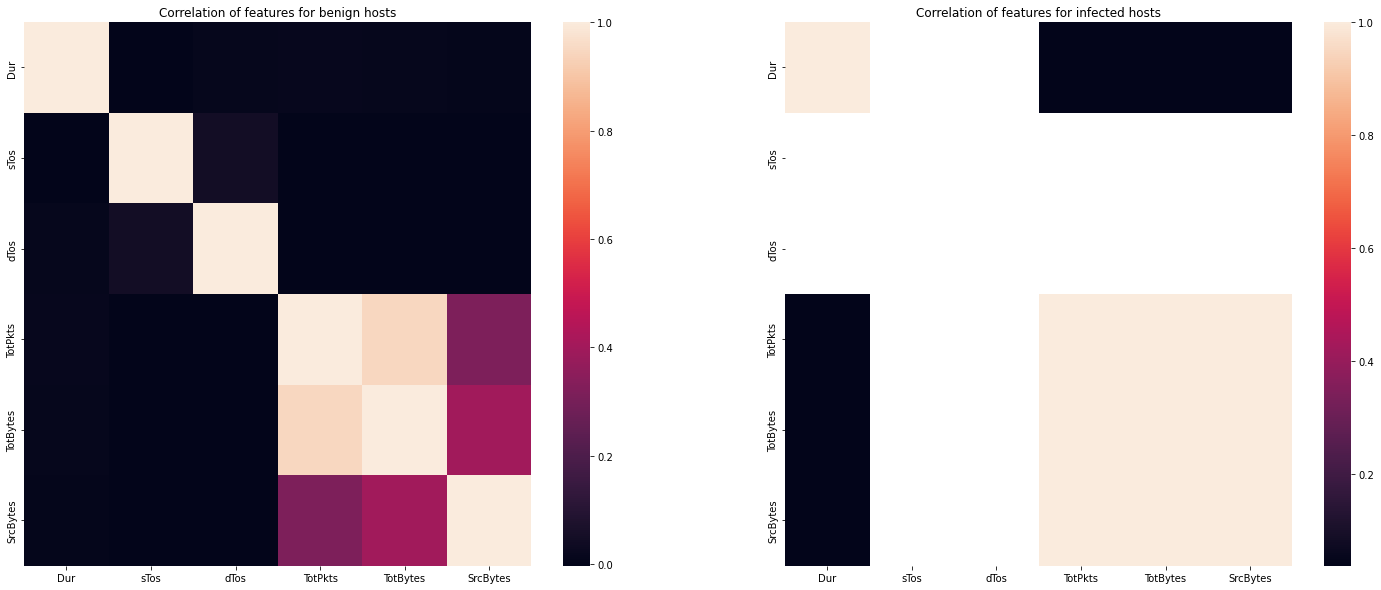

In [51]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

ax1.set_title('Correlation of features for benign hosts')
sns.heatmap(df_benign.corr(), ax=ax1)

ax2.set_title('Correlation of features for infected hosts')
sns.heatmap(df_infected.corr(), ax=ax2)

plt.show()

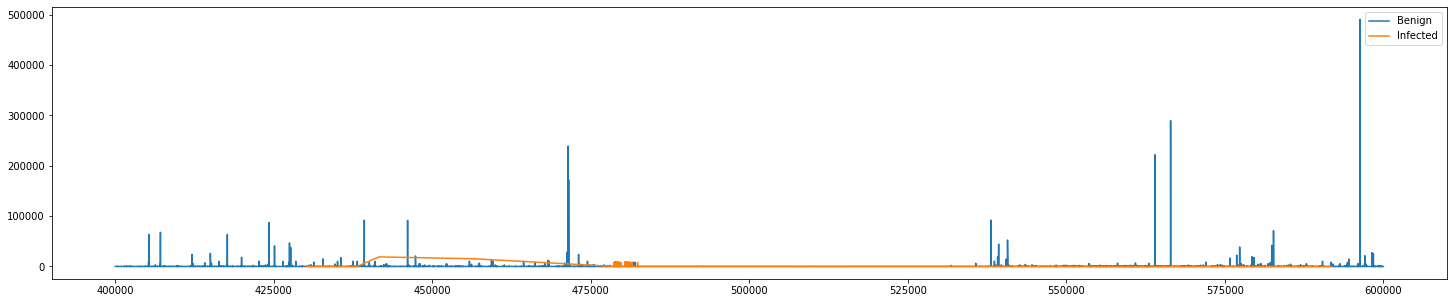

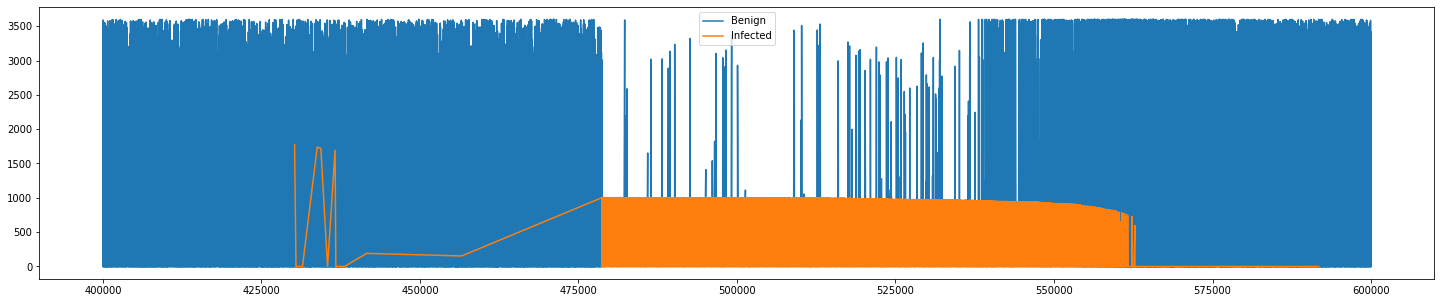

In [44]:
features = ['TotPkts', 'Dur']

df_fragment = df[400000:600000]

df_fragment_infected = filter_infected(df_fragment)
df_fragment_benign = filter_benign(df_fragment)

_, ax = plt.subplots(1, 1, figsize=(25, 5))
ax.plot(df_fragment_benign[features[0]])
ax.plot(df_fragment_infected[features[0]])
ax.legend(labels=['Benign', 'Infected'])
plt.show()

_, ax = plt.subplots(1, 1, figsize=(25, 5))
ax.plot(df_fragment_benign[features[1]])
ax.plot(df_fragment_infected[features[1]])
ax.legend(labels=['Benign', 'Infected'])
plt.show()


### Discretization

In [45]:
def discretize(discretizer, feature_array):
    """
    Discretizes the passed data.

    Arguments:
        discretizer: Discretizer, fitted with the learning data
        feature_array: Numpy array with data to discretize, using the passed discretizer
    Returns:
        Discretized data, passed as feature_array argument
    """
    bins = discretizer.transform(feature_array)[:, 0]
    vectorizer = np.vectorize(lambda x: int(discretizer.bin_edges_[0][int(x)]))

    return vectorizer(bins)

In [99]:
# Ignoring the FutureWarning which is internally thrown by NearestNeighbors
#warnings.simplefilter(action='ignore', category=UserWarning)
# choose a host

host = '147.32.84.165'
df_host = df[df['SrcAddr'] == host]

discretizer1 = KBinsDiscretizer(n_bins=3, strategy='uniform', encode='ordinal')
discretizer2 = KBinsDiscretizer(n_bins=12, strategy='uniform', encode='ordinal')

df_features = []
df_features.append(df_host[[features[0]]].to_numpy())
df_features.append(df_host[[features[1]]].to_numpy())

discretizer1.fit(df_features[0])
discretizer2.fit(df_features[1])

features_discretized = []
features_discretized.append(discretize(discretizer1, df_features[0]))
features_discretized.append(discretize(discretizer2, df_features[1]))

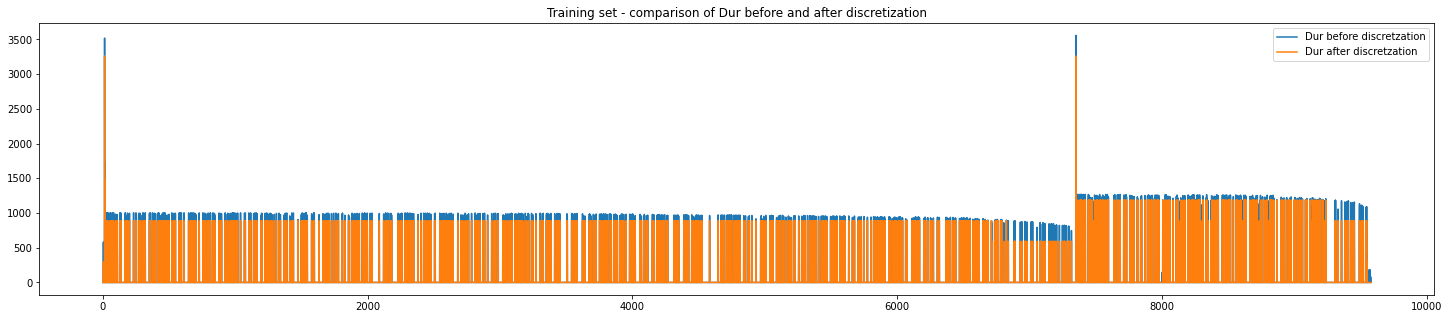

In [89]:
_, ax = plt.subplots(1, 1, figsize=(25, 5))

f_num = 1

#ax.set_ylim([None, 10000])
ax.plot(df_features[f_num])
ax.plot(features_discretized[f_num])

ax.legend(labels=[f'{features[f_num]} before discretzation', f'{features[f_num]} after discretzation'], loc='upper right')
ax.set_title(f'Training set - comparison of {features[f_num]} before and after discretization')
plt.show()

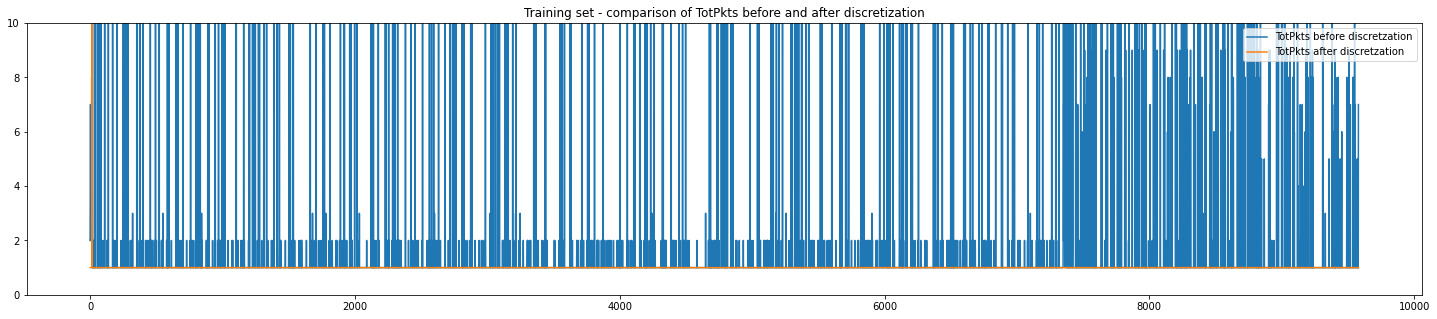

In [100]:
_, ax = plt.subplots(1, 1, figsize=(25, 5))

f_num = 0
ax.set_ylim([None, 10])
ax.plot(df_features[f_num])
ax.plot(features_discretized[f_num])

ax.legend(labels=[f'{features[f_num]} before discretzation', f'{features[f_num]} after discretzation'], loc='upper right')
ax.set_title(f'Training set - comparison of {features[f_num]} before and after discretization')
plt.show()

### Reading data set

### 1b. Discretize selected features

### 1c. Answers and explanation

## 2. Sketching task – 1/2 A4 (Individual, 10 Points)

### 2a. COUNT-MIN sketch


### 2b. Analysis and answers to the questions

## 3. Min-wise locality sensitive hashing task – 1/2 A4 (Individual, 10 Points)

### 3a. Implementation

### 3b. Analysis and answers to the questions

## 4.Botnet profiling and fingerprinting task – 1 A4 (5 Points)

### 4a. Learn a sequential model, profiling and fingerprinting

### 4b. Analysis and answers to the questions.

## 5. Bonus Task 1/2 A4 (5 Points)

### 5a. Provide implementation and analysis.